AlgoTrading回测工具使用
==============
***

1. 策略描述
------------------
***

定义的策略需要继承自``strategy``基类，并且实现两个成员方法：

* ``__init__``，*策略初始化*
* ``handle_data``，*每次新的市场数据到来时运行*

In [1]:
%matplotlib inline
import datetime as dt
from AlgoTrading.Strategy import Strategy
from AlgoTrading.Backtest import strategyRunner
from AlgoTrading.Backtest import DataSource
from PyFin.API import MA
from PyFin.API import MAX
from PyFin.API import MIN

策略信号：

* ``MAX(30, 'close')``：过去30条bar的收盘价的最大值；
* ``MIN(30, 'close')``：过去30条bar的收盘价的最小值；
* ``MA(10, 'close')``：过去10条bar的收盘价的均线；
* ``MA(30, 'close')``：过去30条bar的收盘价均线；
* ``secPos[s]``：获取某只股票的当前仓位；
* 只选过去30条bar收盘价最大值 比上收盘价最小值大于1.002的股票(概念上，我们想选波动率足够大的股票）；
* 当``MA(10, 'close')``，高于``MA(30, 'close')``时，并且当前无仓位，买入；
* 当``MA(10, 'close')``，低于``MA(30, 'close')``时，并且当前有仓位，清空该仓位。

In [2]:
class MovingAverageCrossStrategy(Strategy):
    def __init__(self):
        filtering = (MAX(30, 'close') / MIN(30, 'close')) > 1.002
        self.signal = (MA(10, 'close') - MA(30, 'close'))[filtering]

    def handle_data(self):
        for s in self.universe:
            if self.signal[s] > 0.0 and self.secPos[s] == 0:
                self.order(s, 1, quantity=1000)
            elif self.signal[s] < 0.0 and self.secPos[s] != 0:
                self.order(s, -1, quantity=1000)

2. 策略运行设置
------------------
***

需要设置策略运行的基本参数:

* ``universe``: *证券池*
* ``initialCapital``：*初始资金*
* ``startDate``：*回测开始日期*
* ``endDate``：*回测结束日期*
* ``dataSource``：*数据源*
* ``freq``：回测时间频率（分钟），仅当使用``DataSource.DXDataCenter``时有效。

In [3]:
def run_example():
    universe = ['000001.XSHE', '000002.XSHE', '000004.XSHE', '000005.XSHE', '000006.XSHE', '000007.XSHE', '000008.XSHE']
    initialCapital = 100000.0
    startDate = dt.datetime(2011, 10, 1)
    endDate = dt.datetime(2015, 10, 1)

    strategyRunner(userStrategy=MovingAverageCrossStrategy,
                   initialCapital=initialCapital,
                   symbolList=universe,
                   startDate=startDate,
                   endDate=endDate,
                   dataSource=DataSource.DXDataCenter,
                   freq=5,
                   saveFile=True,
                   plot=True)

3. 策略运行并输出
----------------
***

策略运行之后会在当前页面下做两件事：

* *输出策略的整体表现至图表，并在当前页面下显示*
* *输出策略表现的具体数据至excel表格，默认为当前目录下的* ```performance.xlsx```

数据读取中...
数据读取完成！
开始回测...
回测结束！
Orders : 2611
Fills  : 2611


d:\Miniconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


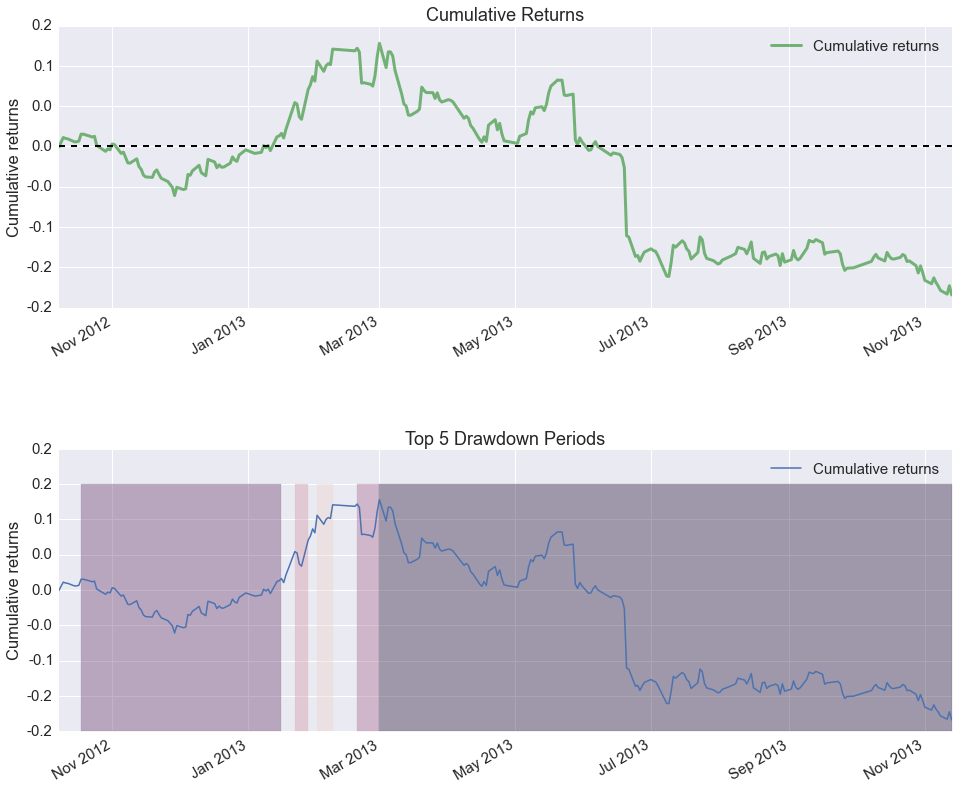

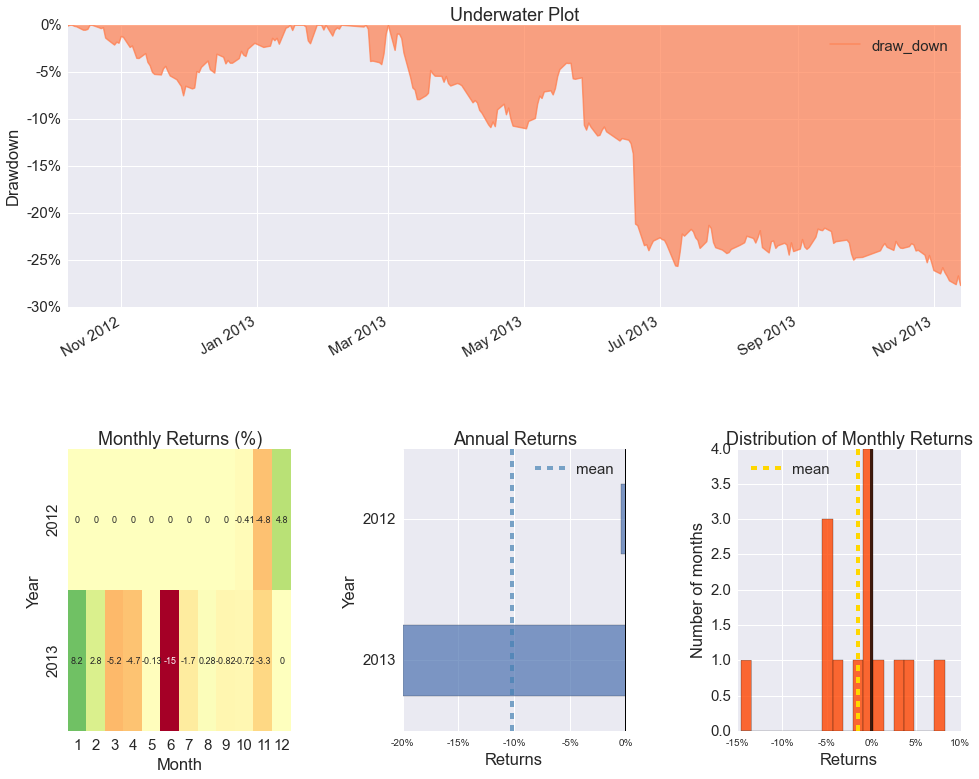

策略表现数据写入excel文件，请稍等...
写入完成！


In [4]:
run_example()

4. 获取表现的表格数据
----------------------
***

In [5]:
import pandas as pd
wb = pd.read_excel('performance.xlsx', sheetname=None)

4.1 策略整体表现
-------------------

In [6]:
wb['perf_metrics']

,metrics
annual_return,-0.1942
annual_volatiltiy,0.1827
sortino_ratio,-1.2262
sharp_ratio,-1.0627
max_draw_down,-0.2767
winning_days,114.0000
lossing_days,150.0000


4.2 策略表现历史时间序列
-------------------------

In [7]:
wb['perf_series'].tail()

,daily_return,daily_cum_return,daily_draw_down
2013-11-07,-0.0053,-0.1732,-0.2670
2013-11-08,-0.0064,-0.1785,-0.2717
2013-11-11,-0.0056,-0.1830,-0.2757
2013-11-12,0.0126,-0.1727,-0.2665
2013-11-13,-0.0139,-0.1841,-0.2767


4.3 策略表现（分证券）
------------------

In [8]:
wb['equity_curve'].tail()

,datetime,000001.xshe,000002.xshe,000004.xshe,000005.xshe,000006.xshe,000007.xshe,000008.xshe,cash,commission,total,return,equity_curve
12666,2013-11-13 14:35:00,13430,0,11850,0,5130,13930,9250,28102.45,13047.55,81692.45,-0.0038,0.8169
12667,2013-11-13 14:40:00,13490,0,11790,0,5120,13930,9290,28102.45,13047.55,81722.45,0.0004,0.8172
12668,2013-11-13 14:45:00,13420,0,11800,0,5120,13880,9280,28102.45,13047.55,81602.45,-0.0015,0.8160
12669,2013-11-13 14:50:00,13330,0,11800,0,5100,13900,9260,28102.45,13047.55,81492.45,-0.0013,0.8149
12670,2013-11-13 14:55:00,13330,0,11760,0,5100,14050,9250,28102.45,13047.55,81592.45,0.0012,0.8159


4.4 策略指令簿
------------------

In [9]:
wb['order_book'].tail()

,orderID,direction,filled,quantity,symbol,time,type
2606,2607,1,1000,1000,000008.xshe,2013-11-13 11:05:00,MKT
2607,2608,-1,1000,1000,000002.xshe,2013-11-13 11:20:00,MKT
2608,2609,1,1000,1000,000001.xshe,2013-11-13 13:05:00,MKT
2609,2610,1,1000,1000,000007.xshe,2013-11-13 13:10:00,MKT
2610,2611,1,1000,1000,000004.xshe,2013-11-13 13:15:00,MKT


4.5 策略成交簿
----------------

In [10]:
wb['filled_book'].tail()

,commission,direction,exchange,fillCost,orderID,quantity,symbol,time
2607,0.00,1,xshe,9370,2607,1000,000008.xshe,2013-11-13 11:05:00
2608,8.82,-1,xshe,-8820,2608,1000,000002.xshe,2013-11-13 11:20:00
2609,0.00,1,xshe,13820,2609,1000,000001.xshe,2013-11-13 13:05:00
2610,0.00,1,xshe,14000,2610,1000,000007.xshe,2013-11-13 13:10:00
2611,0.00,1,xshe,11920,2611,1000,000004.xshe,2013-11-13 13:15:00
